# Load and Save Tensorflow Models

### Dependencies for Loading and Saving
https://www.tensorflow.org/tutorials/keras/save_and_load \
`pip install pyyaml h5py`  # Required to save models in HDF5 format

In [1]:
import os
from pathlib import Path
import json
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt
import numpy as np

2022-05-13 15:16:41.270897: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-13 15:16:41.270914: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
print(tf.version.VERSION)

2.8.0


### Load Data
https://www.tensorflow.org/datasets/catalog/goemotions

In [3]:
import tensorflow_datasets as tfds

In [4]:
data, info = tfds.load(
    "goemotions",
    with_info=True,
)

2022-05-13 15:16:48.039064: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 15:16:48.039484: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-13 15:16:48.039537: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-05-13 15:16:48.039583: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-05-13 15:16:48.039627: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [ ]:
info

In [5]:
emotions = dict(info.features)
#emotions

In [6]:
emotions.pop("comment_text")

Text(shape=(), dtype=tf.string)

In [ ]:
#emotions

In [7]:
data_train_original = data["train"]
data_valid_original = data["validation"]
data_test_original = data["test"]

#### Inspect the Dataset

In [ ]:
print("train:", len(data_train_original))
print("valid:", len(data_valid_original))
print("test:", len(data_test_original))

In [ ]:
for comment in data_train_original.take(4):
    print(comment["comment_text"].numpy())
    [print(emotion,": ", comment[emotion].numpy()) for emotion in comment if (emotion!="comment_text") & (str(comment[emotion].numpy())=="True")]
    label = [float(comment[emotion]) for emotion in comment if emotion!="comment_text"]
    print(label)
                   

### Build Model

#### Helper Functions

##### Plot Model History

In [8]:
def render_history(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()
    
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.show()
    plt.close()

#### Save Checkpoints During Training - Callback Function

In [9]:
model_dir = "../../models/tf_load_and_save_tf/model1/"

saved_dir = model_dir + "saved/"
checkpoint_dir = model_dir + "cp/"
history_dir = model_dir + "history/"

checkpoint_path = checkpoint_dir + "cp-{epoch:02d}.ckpt"


Path(saved_dir).mkdir(parents=True, exist_ok=True)
Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)
Path(history_dir).mkdir(parents=True, exist_ok=True)

In [10]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1
)

In [11]:
# Test if directory is accessible
print(checkpoint_path)
print(checkpoint_dir)
!ls -a $checkpoint_dir

../../models/tf_load_and_save_tf/model1/cp/cp-{epoch:02d}.ckpt
../../models/tf_load_and_save_tf/model1/cp/
.  ..


#### Set Hyperparameters

In [12]:
vocabulary_size = 10_000
sequence_length = 32
batch_size = 16
epochs = 5

#### Define Encoder

In [13]:
encoder = layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_sequence_length=sequence_length,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int",
)

In [14]:
encoder.adapt(data_train_original.map(lambda comment: comment["comment_text"]).batch(1024))

In [15]:
vocabulary = encoder.get_vocabulary()
print(encoder.vocabulary_size(), vocabulary[:50])

10000 ['', '[UNK]', 'the', 'i', 'to', 'a', 'you', 'and', 'is', 'that', 'name', 'it', 'of', 'this', 'in', 'for', 'was', 'my', 'not', 'but', 'be', 'on', 'so', 'just', 'have', 'are', 'like', 'with', 'me', 'they', 'your', 'he', 'what', 'its', 'if', 'as', 'im', 'at', 'all', 'about', 'no', 'do', 'love', 'one', 'get', 'people', 'we', 'would', 'good', 'dont']


In [16]:
data_train = data_train_original.map(lambda comment: (comment.pop("comment_text"), [float(comment[emotion]) for emotion in comment]))
data_train = data_train.cache()
data_train = data_train.shuffle(50_000)
data_train = data_train.batch(batch_size)

data_valid = data_valid_original.map(lambda comment: (comment.pop("comment_text"), [float(comment[emotion]) for emotion in comment]))
data_valid = data_valid.cache()
data_valid = data_valid.batch(batch_size)

data_test = data_test_original.map(lambda comment: (comment.pop("comment_text"), [float(comment[emotion]) for emotion in comment]))
data_test = data_test.cache()
data_test = data_test.batch(batch_size)

In [ ]:
for x, y in data_train.take(1):
    print(x)
    print(y)

#### Define Model

In [17]:
def create_model():
    model = models.Sequential()
    
    model.add(encoder)
    model.add(layers.Dense(16, activation="relu"))
    model.add(layers.Dense(28, activation="sigmoid"))
    
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
        
    return model

In [18]:
model1 = create_model()
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 32)               0         
 torization)                                                     
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 28)                476       
                                                                 
Total params: 1,004
Trainable params: 1,004
Non-trainable params: 0
_________________________________________________________________


#### Train Model 1

Epoch 1/5
2687/2714 [============================>.] - ETA: 0s - loss: 8.3162 - accuracy: 0.1999
Epoch 1: saving model to ../../models/tf_load_and_save_tf/model1/cp/cp-01.ckpt
2714/2714 [==============================] - 6s 2ms/step - loss: 8.2395 - accuracy: 0.2009 - val_loss: 0.3363 - val_accuracy: 0.2857
Epoch 2/5
2701/2714 [============================>.] - ETA: 0s - loss: 0.2151 - accuracy: 0.2929
Epoch 2: saving model to ../../models/tf_load_and_save_tf/model1/cp/cp-02.ckpt
2714/2714 [==============================] - 4s 1ms/step - loss: 0.2149 - accuracy: 0.2927 - val_loss: 0.1693 - val_accuracy: 0.2879
Epoch 3/5
2684/2714 [============================>.] - ETA: 0s - loss: 0.1570 - accuracy: 0.2982
Epoch 3: saving model to ../../models/tf_load_and_save_tf/model1/cp/cp-03.ckpt
2714/2714 [==============================] - 4s 2ms/step - loss: 0.1569 - accuracy: 0.2982 - val_loss: 0.1532 - val_accuracy: 0.2962
Epoch 4/5
2698/2714 [============================>.] - ETA: 0s - loss: 0.

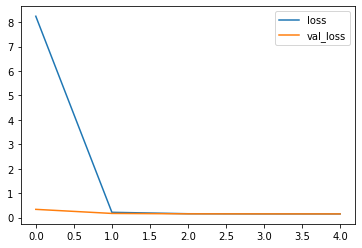

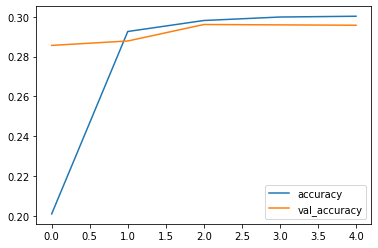

In [19]:
history = model1.fit(
    data_train,
    epochs=epochs,
    validation_data=data_valid,
    callbacks=[cp_callback]
)

render_history(history)

#### Test Model 1 on Test Data

In [20]:
model1.evaluate(data_test)

340/340 [==============================] - 1s 2ms/step - loss: 0.1478 - accuracy: 0.3004


[0.14780865609645844, 0.3003500998020172]

### Saving

#### Safe the Model

In [21]:
model1.save(saved_dir)

2022-05-13 15:18:17.990322: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../../models/tf_load_and_save_tf/model1/saved/assets


INFO:tensorflow:Assets written to: ../../models/tf_load_and_save_tf/model1/saved/assets


#### Safe Model History - as JSON

In [37]:
history_path_json = history_dir + "model1_history.json"
json.dump(history.history, open(history_path_json, 'w'))

#### Safe Model History - as CSV with Pandas

In [38]:
history_path_csv = history_dir + "model1_history.csv"
pd.DataFrame.from_dict(history.history).to_csv(history_path_csv, index=False)

### Loading

#### Create a New Model with the same Architecture as Model 1

In [24]:
model2 = create_model()

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 32)               0         
 torization)                                                     
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 28)                476       
                                                                 
Total params: 1,004
Trainable params: 1,004
Non-trainable params: 0
_________________________________________________________________


#### Test the Untrained Model

In [25]:
model2.evaluate(data_test)

340/340 [==============================] - 1s 949us/step - loss: 150.5754 - accuracy: 0.0223


[150.5753936767578, 0.02229592762887478]

#### Load Weights from First Model

In [26]:
!ls $checkpoint_dir

checkpoint			cp-03.ckpt.index
cp-01.ckpt.data-00000-of-00001	cp-04.ckpt.data-00000-of-00001
cp-01.ckpt.index		cp-04.ckpt.index
cp-02.ckpt.data-00000-of-00001	cp-05.ckpt.data-00000-of-00001
cp-02.ckpt.index		cp-05.ckpt.index
cp-03.ckpt.data-00000-of-00001


In [27]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'../../models/tf_load_and_save_tf/model1/cp/cp-05.ckpt'

In [29]:
# model2.load_weights(checkpoint_dir + "/cp-03.ckpt")
model2.load_weights(latest)

#### And Test Again

In [30]:
model2.evaluate(data_test)

340/340 [==============================] - 0s 986us/step - loss: 0.1478 - accuracy: 0.3004


[0.14780865609645844, 0.3003500998020172]

#### Load Complete Model

In [31]:
model3 = tf.keras.models.load_model(saved_dir)

In [32]:
model3.evaluate(data_test)

340/340 [==============================] - 0s 967us/step - loss: 0.1478 - accuracy: 0.3004


[0.14780865609645844, 0.3003500998020172]

#### Load and Plot History

In [39]:
history_loaded = json.load(open(history_path_json, "r"))

In [41]:
model2.history.history = history_loaded

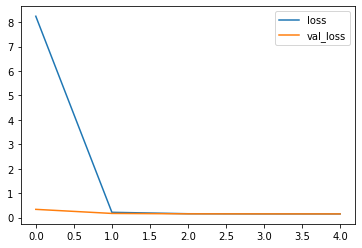

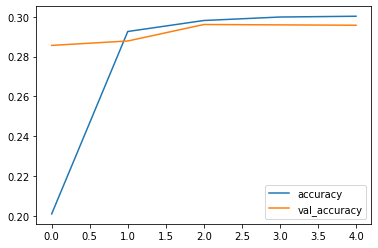

In [42]:
render_history(model2.history)